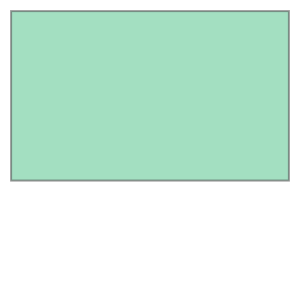

In [23]:
import earthpy.spatial as es
import numpy as np
import os, sys
import geopandas as gpd
import rasterio as rio
from shapely.geometry import box
from glob import glob
from tqdm import tqdm

# Set target_shapefile to the appropriate coordinates
# Create a box from the total_bounds of the shapefile
target_shapefile = gpd.read_file("singapore_boundary.geojson")
target_shapefile = target_shapefile.to_crs("EPSG:32648")
xmin, ymin, xmax, ymax = target_shapefile.total_bounds
target_shapefile = box(np.floor(xmin), np.floor(ymin), np.ceil(xmax), np.ceil(ymax))

target_shapefile

In [25]:
%%time
### WORKED PERFECTLY ###

# List of scenes
folder_list = os.listdir("./data_cloud_imputing")
band_paths_list = []

# Find all bands in 
for scene in tqdm(folder_list):
    output_dir = os.path.join(
        os.getcwd(), 
        "data_cloud_imputing",
        scene
    )
    
    stack_band_paths = glob(
        os.path.join(
            os.getcwd(),
            "data_cloud_imputing",
            scene,
            "*B*.TIF"
        )
    )
    
    stack_qa_paths = glob(
        os.path.join(
            os.getcwd(),
            "data_cloud_imputing",
            scene,
            "*QA_PIXEL.TIF"
        )
    )

    paths_to_crop = stack_band_paths + stack_qa_paths
    
    # This function will crop all of the specified bands and write them into the specified output 
    # directory. it returns a list of file paths which you can then use as the input for es.stack 
    # in order to stack the bands into a multi band raster.
    
    # note that this expects a list of polygons, so you need to put it in a list even if its just the
    # one polygon
    band_paths = es.crop_all(
        paths_to_crop, output_dir, [target_shapefile], overwrite=True
    )
    
    band_paths_list.append(band_paths)
    
#     # do this to delete original files to save space
#     # only uncomment if you are SURE YOU WANT TO DO THIS
#     for file in paths_to_crop:
#         os.remove(file)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]

CPU times: total: 1.14 s
Wall time: 1.54 s


In [34]:
# Using the band parts returned by the es.crop_all function, we can create multiband rasters in 
# their respective folders using a single command
for folder in band_paths:
    # This outputs the data into the data_cloud_imputing folder
    # a bit wrong but its fine
    stack, metadata = es.stack(folder[:-1], out_path = f"{os.path.dirname(folder[0])}_STACKED.tif")

In [ ]:
# When you need to crop and stack a set of images, it is most efficient to first crop each image, and then stack it.
# es.crop_all() is an efficient way to crop all bands in an image quickly. The function will write out cropped rasters
# to a directory and return a list of file paths that can then be used with es.stack().

# the following syntax can be used

band_paths_list = es.crop_all(
    stack_band_paths, output_dir, target_shapefile, overwrite=True
)

# band_paths_list is a list of all filepaths created by the crop_all function
# stack_band_paths is a list of all filepaths to be cropped
# output_dir (string) is the output directory in which the cropped files will be returned; all images 
# produced will have the _crop suffix
# crop_bound is a geojson object of the bounds of the area of interest - as always, note that
# they must be in the same CRS - note that this takes in a geopandas dataframe
# overwrite will force overwrite any existing cropped files

In [ ]:
# es.crop_image() can be used for single image cropping - it takes in a rasterio object and crops it to a specified geojson object